<a href="https://colab.research.google.com/github/bevanyeah/trashr-dqn/blob/main/DQN3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# R-DQN on Cartpole

## Bevan Fairleigh


# Paper Review

In recent years, we have seen many new publications with solutions to combine Deep Q-learning reinforcement network and return-based algorithms.  Such publications include Watkin’s Q(λ) and Tree-Backup(λ) which are covered in Sutton and Barto ( REFERENCE), as well are more recent techniques such as Importance Sampling (IS) and Retrace(λ) ( REFERENCE).  

However, these approaches either benefit from near on-policy situations, when our target policy and behaviour policy are very similar, or they benefit from near off-policy situations where these two policies are different.

Our paper in review proposes a method to measure the policy discrepancy to select which return algorithm may be of most use.  It’s framework, named R-DQN, is suggested to provide benefit to most of the previously presented frameworks through it’s proposed method of qualitatively measure any policy discrepancy, QM(λ).


## Policy Discrepancy Measure

QM(λ) works by altering the trace coefficient (Cs) based on whether we have a near on-policy or near off-policy network.  
 
For on-policy cases, we take the minimum of 1 or the ratio between our two policies (multiplied by λ).  This is the proposed method in Retrace(λ) but was shown to be unstable when our target and behaviour policies were significantly different.

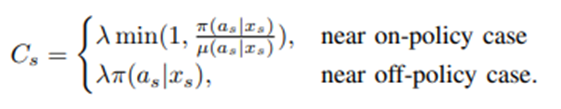

For off-policy cases, we take the much smaller coefficient from our current target policy.  This is as described in Tree-backup(λ).
We also need a proposed method for determining the difference between on-policy and off-policy cases, which can be determined automatically to a degree.  First, we must select a method for which we make this assessment.

We also need a proposed method for determining the difference between on-policy and off-policy cases, which can be determined automatically to a degree.  First, we must select a method for which we make this assessment.
 
Essentially, we can measure the distance between our target policy and behaviour policy, either via L1 norm of the difference between states (β), or absolute value of the difference between the state-action pair (η).  The paper suggests that β should be used when an agent has limited impact on the environment, while η should be used when the environment can be altered by the agent.



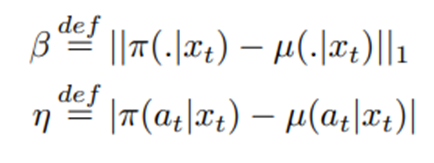

Using β or η methods, we can determine if we have an on-policy or off-policy case.  
For β, where β can be derived as


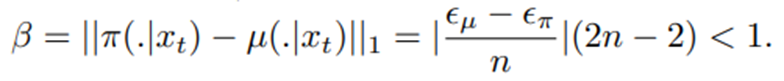

Where n is the number of action states and ξμ and ξπ are the epsilon-greedy parameters for behaviour policy and target policy respectively.  
When β<1, we can treat the problem as near-on policy.  Otherwise it’s near-off policy.
For η, where η can be derived as


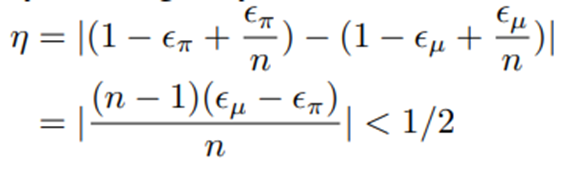

Where n is the number of action states and ξμ and ξπ are the epsilon-greedy parameters for behaviour policy and target policy respectively.  
When η < 1/2, we can treat the problem as near-on policy. Otherwise it’s near-off policy.
This gives us access to calculate our trace coefficient Cs as per the current scenario experienced while training.

## Experience Replays

The R-DQN implementation make use of a Experience Replay to learn from previously experienced states.  R-DQN draws samples from the replay memory in sequential order to ensure the trace can be appropriately calculated and applied to the network weights.


The overall process of the R-DQN framework is summarised below.


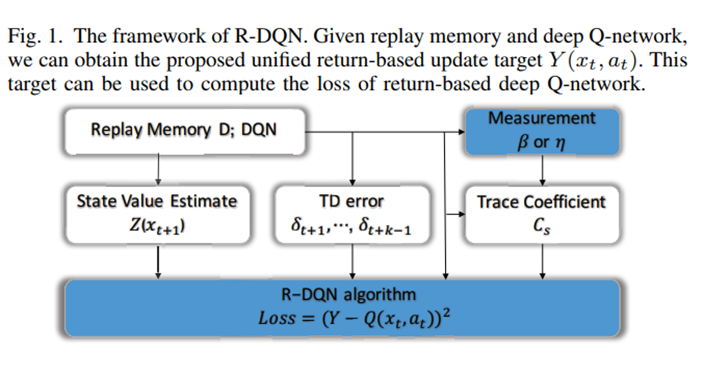

# Implementation

This code has been developed from a DQN tutorial provided by Jon Krohn https://www.youtube.com/watch?v=OYhFoMySoVs&t=62s

https://github.com/jonkrohn/TensorFlow-LiveLessons/tree/master/notebooks

It has been modified to accomodate a return-based algorithm as proposed in https://arxiv.org/pdf/1806.06953.pdf


Our implementation of this code was built mostly scratch, except for a few borrowed components taken from Jon Krohn tutorial on DQN.

The implementation follows the psuedocode provided in the original paper closely.



#### Import dependencies

In [25]:
import random
import tensorflow as tf

import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import os # for creating directories
import numpy as np

#### Set parameters

In [26]:
env = gym.make('CartPole-v0') # initialise environment

state_size = env.observation_space.shape[0]
action_size = env.action_space.n


batch_size = 32
n_episodes = 400

replacement_freq = 50

output_dir = 'model_output/cartpole/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [27]:

import random


'''
ExperienceReplay is our sequential list of experiences already discovered through previous iterations of running our environment.  
With each new step, we want to ensure we store the full transition information is captured, as well as our behaviour policy.  

When calling for a sample from the experience reply, we must input our random int, and capture the sequential experience from that location.
If however the experience reaches terminal state, we must provide a truncated list.

'''
class ExperienceReplay():

    def __init__(self, capacity):

      self.memory = deque(maxlen=capacity)

    # Adds a memory to our replay
    def add(self, state, action, reward, next_state, done, behaviour_action):

      self.memory.append([state, action, reward, next_state, done, behaviour_action])
      return

    def reset(self):
      self.memory = deque(maxlen=5000)

    def get_sample(self, start=0 ):

      sample = []
      stop= start + batch_size

      for i in range(start,stop):
        # Copy the elements of the memory 1 at a time
        sample.append(self.memory[i]) 
        
        # if end state, return the current list
        if (self.memory[i][4]==True or len(self.memory)==i):
          return sample
      
      return sample

    def get_random_start(self):
      return random.randint(0, len(self.memory)-1)

    def get_length(self):
      return len(self.memory)


def to_tensor(x):
    if tf.is_tensor(x):
        return x
    else:
        # print(x)
        x = np.asarray(x).astype('float32')
        x = tf.convert_to_tensor(x)
        if len(tf.shape(x))==1:
          x = tf.expand_dims(x, axis=0)
        return x




#### Define agent

In [28]:
from keras.backend import dtype
import math
from tensorflow.python.ops.variables import trainable_variables
class r_dqn_agent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        self.memory = ExperienceReplay(400)

        self.gamma = 0.95 
        self.epsilon_pi = 0.8   
        self.epsilon_mu = 0.8
        self.epsilon_decay = 0.995 
        self.epsilon_min = 0.01 
        self.learning_rate = 0.01 
        self.lambda_ = 0.5 


        self.qmodel = self._build_model() 
        self.behav_qmodel = self._build_model()
        self.behav_qmodel.set_weights(self.qmodel.get_weights())

        self.optimiser = Adam(learning_rate=self.learning_rate)

        self.steps = 0
    
    def _build_model(self):

        model = Sequential()
        model.add(Dense(48, input_dim=self.state_size, activation='relu',kernel_initializer='random_normal',)) 
        model.add(Dense(48, activation='relu',kernel_initializer='random_normal',))
        model.add(Dense(self.action_size, activation='linear'))
        return model
    

    # CHECK Q model for action
    def act(self, state):
        if np.random.rand() <= self.epsilon_mu: # if acting randomly, take random action
            return random.randrange(self.action_size)
        act_values = self.qmodel.predict(state) # if not acting randomly, predict reward value based on current state
        return np.argmax(act_values[0]) # pick the action that will give the highest reward (i.e., go left or right?)
    
    # CHECK TARGET Q model for action
    def behave(self,state):
        behave_values = self.behav_qmodel.predict(state) 
        return np.argmax(behave_values[0])

    def update_two(self):

        # get a t, our random start position
        t = self.memory.get_random_start()

        # get a sequential batch
        sample = np.array(self.memory.get_sample(start=t))
        # print(sample[:,1])
        states = to_tensor(sample[:,0][0][0])
        actions = tf.cast(to_tensor(sample[:,1][0]),tf.int64)
        rewards = to_tensor(sample[:,2][0])
        next_states = to_tensor(sample[:,3][0][0])
        dones = to_tensor(sample[:,4][0])
        behavs =  tf.cast(to_tensor(sample[:,5][0]),tf.int64)


        tf_lambda = tf.constant(self.lambda_, dtype=np.float32)
        tf_gamma = tf.constant(self.gamma,dtype=np.float32 )
        one = tf.constant(1.0)
        
        with tf.GradientTape() as tape:
          
          # Our first sates, at position t
          vals = self.qmodel(states)
          
          next_state_vals = self.qmodel(next_states)

          first_rewards = rewards

          currentQvalue = tf.reduce_max(self.qmodel(states))

          Z = tf.reduce_max(next_state_vals)
      
          sum = 0
          
          #  from s = t+1 (which is 1) to t+k-1, which is our sample length
          for s in range(1,len(sample)):
            

            states = to_tensor(sample[:,0][s][0])
            actions = tf.cast(to_tensor(sample[:,1][s]),tf.int64)
            rewards = to_tensor(sample[:,2][s])
            next_states = to_tensor(sample[:,3][s][0])

            # get the new values
            vals = self.qmodel(states)
            next_state_vals = self.qmodel(next_states)

            C_product = 1
            for i in range(1, s+1):

              # Calculate the current state of the Trace
              current_state = to_tensor(sample[:,0][i][0])

              # Using B
              # Are we greedy and matching our critic?
              if tf.math.argmax(self.qmodel(current_state))[0] == tf.math.argmax(self.behav_qmodel(current_state))[0]:
                ratio = 1
              else:
                ratio = 0.5

              

              # if greedy:
              #   # Near on policy
              #   # Largest is can ever be is 0.25*... always be near on-policy b is less than 1.
              C_product = C_product * self.lambda_ * ratio


            # P&W's
            delta = rewards + tf_gamma*(tf.reduce_max(next_state_vals)) - tf.reduce_max(vals)
            # print(f"delta {delta}")
            # Watkins
            # delta = rewards + tf_gamma * tf.reduce_max(next_state_vals) + vals_with_action
            

            sum = sum + (self.gamma**(s))*C_product*delta     
            # print(f"sum {sum}")  

          Y = first_rewards + tf_gamma * Z + sum
 
          td_error = (Y - currentQvalue)**2

        gradients = tape.gradient(td_error, self.qmodel.trainable_variables)
        self.optimiser.apply_gradients(zip(gradients, self.qmodel.trainable_variables))

        if self.epsilon_mu > self.epsilon_min:
          self.epsilon_mu *= self.epsilon_decay
        
        self.steps += 1

        if self.steps%replacement_freq ==0:
          print("Updating our Weights for behaviour network")
          self.behav_qmodel.set_weights(self.qmodel.get_weights())

    def load(self, name):
        self.qmodel.load_weights(name)

    def save(self, name):
        self.qmodel.save_weights(name)

#### Interact with environment

In [29]:
agent = r_dqn_agent(state_size, action_size) 

In [30]:

for e in range(n_episodes): 
    state = env.reset() 
    state = np.reshape(state, [1, state_size])
    done = False
    steps = 0
    while not done: 

        steps+=1
        action = agent.act(state) 
        behaviour_action =  agent.behave(state)
        next_state, reward, done, _ = env.step(action)   

        reward = reward if not done else -100         
        next_state = np.reshape(next_state, [1, state_size])
        
        agent.memory.add(state, action, reward, next_state, done, behaviour_action)
      
        state = next_state     
        if done: 
            print("episode: {}/{}, score: {}, e: {:.2}"
                  .format(e, n_episodes, steps, agent.epsilon_mu))


    
    if agent.memory.get_length() > batch_size:
        
        agent.update_two()
        # agent.memory.reset() 
      

episode: 0/400, score: 29, e: 0.8
episode: 1/400, score: 65, e: 0.8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


episode: 2/400, score: 27, e: 0.8
episode: 3/400, score: 23, e: 0.79
episode: 4/400, score: 12, e: 0.79
episode: 5/400, score: 20, e: 0.78
episode: 6/400, score: 15, e: 0.78
episode: 7/400, score: 15, e: 0.78
episode: 8/400, score: 17, e: 0.77
episode: 9/400, score: 34, e: 0.77
episode: 10/400, score: 11, e: 0.76
episode: 11/400, score: 20, e: 0.76
episode: 12/400, score: 60, e: 0.76
episode: 13/400, score: 20, e: 0.75
episode: 14/400, score: 35, e: 0.75
episode: 15/400, score: 48, e: 0.75
episode: 16/400, score: 49, e: 0.74
episode: 17/400, score: 32, e: 0.74
episode: 18/400, score: 65, e: 0.73
episode: 19/400, score: 37, e: 0.73
episode: 20/400, score: 17, e: 0.73
episode: 21/400, score: 24, e: 0.72
episode: 22/400, score: 13, e: 0.72
episode: 23/400, score: 19, e: 0.72
episode: 24/400, score: 24, e: 0.71
episode: 25/400, score: 14, e: 0.71
episode: 26/400, score: 24, e: 0.71
episode: 27/400, score: 16, e: 0.7
episode: 28/400, score: 12, e: 0.7
episode: 29/400, score: 14, e: 0.7
epis